## [盘一盘 Python 系列 8 - sklearn](https://mp.weixin.qq.com/s/ZJGX1o3KZ0uwILjKxeAtVQ)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 4 高级API
Sklearn 里核心 API 接口是估计器，那高级 API 接口就是元估计器 (meta-estimator)，即由很多基估计器 (base estimator) 组合成的估计器。

类比[Python 入门篇 (下)](https://mp.weixin.qq.com/s/3i0o4ferIpP9sTz1clgRzg)一贴里的把函数当成参数的高阶函数，元估计器把估计器当成参数。代码范式大概如下：
```python
meta_model( base_model )
```

本节讨论五大元估计器，分别带集成功能的`ensemble`，多分类和多标签的`multiclass`，多输出的`multioutput`，选择模型的`model_selection`，和流水线的`pipeline`。

- ensemble.BaggingClassifier
- ensemble.VotingClassifier
- multiclass.OneVsOneClassifier
- multiclass.OneVsRestClassifier
- multioutput.MultiOutputClassifier
- model_selection.GridSearchCV
- model_selection.RandomizedSearchCV
- pipeline.Pipeline

在下面五节，我们会用的鸢尾花数据 iris 和数字数据 digits，还有一些自己创建的数据。

### 4.1 Ensemble 估计器
Ensemble 估计器是用来做集成学习，该估计器里面有若干个分类器 (classifier) 或回归器 (regressor)。详情参考[集成学习前传](https://mp.weixin.qq.com/s/T3d9pqnu643K6Nxj7-ztFg)一贴。

- 分类器统计每个子分类器的预测类别数，再用「多数投票」原则得到最终预测。
- 回归器计算每个子回归器的预测平均值。

最常用的 `Ensemble 估计器`排列如下：

- AdaBoostClassifier: 逐步提升分类器
- AdaBoostRegressor: 逐步提升回归器
- BaggingClassifier: 装袋分类器
- BaggingRegressor: 装袋回归器
- GradientBoostingClassifier: 梯度提升分类器
- GradientBoostingRegressor: 梯度提升回归器
- RandomForestClassifier: 随机森林分类器
- RandomForestRegressor: 随机森林回归器
- VotingClassifier: 投票分类器
- VotingRegressor: 投票回归器

我们用鸢尾花数据 iris，拿

- 含`同质`估计器 RandomForestClassifier 
- 含`异质`估计器 VotingClassifier 

来举例。首先将数据分成 80:20 的训练集和测试集，并引入 `metrics` 来计算各种性能指标。

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], test_size=0.2)

#### RandomForestClassifier
随机森林(random forest)是决策树(decision tree)的一种集成模型，每棵决策树处理的数据用装袋法(bagging)生成。随机森林可以减小预测的方差，并且可以评估特征重要性。详情参考[随机森林和提升树](https://mp.weixin.qq.com/s/mf4QIw6pILRoin50O4t1pg)一贴。

`RandomForestClassifier`通过控制`n_estimators`超参数决定基估计器的个数，本例是 4 棵决策树（森林由树组成）；此外每棵树的最大树深为(`max_depth=5`)。

In [4]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=4, max_depth=5)
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

估计器有 `fit()`，元估计器当然也有 `fit()`。估计器那一套又可以照搬到元估计器 (起名 `RF`) 上了。看看 `RF` 里包含的估计器个数和其本身。

In [5]:
print(RF.n_estimators)

4


In [6]:
RF.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=487729243, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=2110295200, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                        max_features='auto', max_leaf_nodes=None,
                        min

拟合 `RF` 完再做预测，用 `metrics`  里面的 `accuracy_score` 来计算准确率。训练准确率 99.17%，测试准确率 93.33%。

In [7]:
print(f"RF - Accuracy(Train): {metrics.accuracy_score(y_train, RF.predict(X_train)):.4f}")
print(f"RF - Accuracy(Test): {metrics.accuracy_score(y_test, RF.predict(X_test)):.4f}")

RF - Accuracy(Train): 0.9917
RF - Accuracy(Test): 0.8667


#### VotingClassifier
和随机森林由`同质`分类器（决策树）组成不同，投票分类器由若干个`异质`分类器组成。

下例用`VotingClassifier`建立含有对率回归(LR)、随机森林(RF)和高斯朴素贝叶斯(GNB)三个分类器的集成模型。

`RandomForestClassifier`的基分类器只能是决策树，因此只用通过控制 `n_estimators` 超参数来决定树的个数，而 `VotingClassifier`的基分类器要实实在在的输入基本身。

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [9]:
LR = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=300)
RF = RandomForestClassifier(n_estimators=5)
GNB = GaussianNB()

Ensemble = VotingClassifier(
                estimators=[('lr', LR), ('rf', RF), ('gnb', GNB)],
                voting='hard')
Ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=300,
                                                 multi_class='multinomial',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion...
                                        

`Ensemble`里包含的估计器个数和其本身

In [10]:
print(len(Ensemble.estimators_))

3


In [11]:
Ensemble.estimators_

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=300,
                    multi_class='multinomial', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=5,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 GaussianNB(priors=None, var_smoothing=1e-09)]

元估计器和它三个组成元素的表现。还是集成后的`Ensemble`表现最好。

In [12]:
LR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
GNB.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [15]:
print(f"LR - Accuracy(Train): {metrics.accuracy_score(y_train, LR.predict(X_train)):.4f}")
print(f"RF - Accuracy(Train): {metrics.accuracy_score(y_train, RF.predict(X_train)):.4f}")
print(f"GNB - Accuracy(Train): {metrics.accuracy_score(y_train, GNB.predict(X_train)):.4f}")
print(f"Ensemble - Accuracy(Train): {metrics.accuracy_score(y_train, Ensemble.predict(X_train)):.4f}")

LR - Accuracy(Train): 0.9917
RF - Accuracy(Train): 0.9917
GNB - Accuracy(Train): 0.9667
Ensemble - Accuracy(Train): 0.9917


In [16]:
print(f"LR - Accuracy(Test): {metrics.accuracy_score(y_test, LR.predict(X_test))}")
print(f"RF - Accuracy(Test): {metrics.accuracy_score(y_test, RF.predict(X_test))}")
print(f"GNB - Accuracy(Test): {metrics.accuracy_score(y_test, GNB.predict(X_test)):.4f}")
print(f"Ensemble - Accuracy(Test): {metrics.accuracy_score(y_test, Ensemble.predict(X_test))}")

LR - Accuracy(Test): 0.9
RF - Accuracy(Test): 0.8666666666666667
GNB - Accuracy(Test): 0.9333
Ensemble - Accuracy(Test): 0.9


### 4.2 Multiclass 估计器
`sklearn.multiclass`可以处理多类别(multi-class)的多标签(multi-lable)的分类问题。

从小节4.2到4.4，都会使用数字数据集`digits`。

In [17]:
from sklearn.datasets import load_digits

In [18]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(digits['data'], digits['target'], test_size=0.2)

In [20]:
print( 'The size of X_train is ', X_train.shape )
print( 'The size of y_train is ', y_train.shape )
print( 'The size of X_test is ', X_test.shape )
print( 'The size of y_test is ', y_test.shape )

The size of X_train is  (1437, 64)
The size of y_train is  (1437,)
The size of X_test is  (360, 64)
The size of y_test is  (360,)


训练集和测试集分别有1437t 360张图像。每张照片是包含 8 X 8 的像素，将其打平(flatten)把 2 维的 8 X 8 重塑成 1 维的 64。

看看训练集中前 100 张图片和对应的标签（左下角蓝色小字）。像素很低（为了我们跑模型快些），但基本上还是能看清。

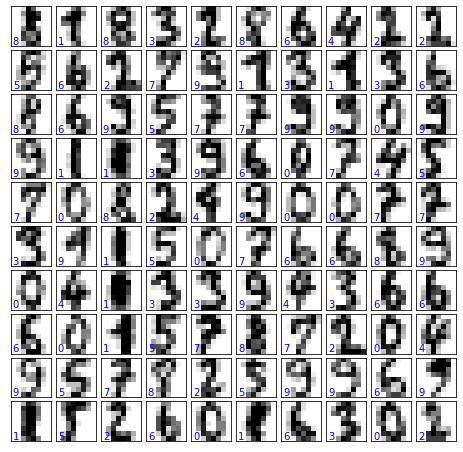

In [21]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i, :].reshape(8, 8), cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_train[i]),
            transform=ax.transAxes, color='blue')
    ax.set_xticks([])
    ax.set_yticks([])

#### 多类别分类

手写数字有 0-9 十类，但手头上只有**两分类估计器** (比如像支撑向量机) 怎么用呢？我们可以采取下面三种常见策略：

- **一对一** (One vs One, OvO)：一个分类器用来处理数字 0 和数字 1，一个用来处理数字 0 和数字 2，一个用来处理数字 1 和 2，以此类推。N 个类需要 N(N-1)/2 个分类器。

- **一对其他** (One vs All, OvA)：训练 10 个二分类器，每一个对应一个数字，第一个分类 1 和「非1」，第二个分类 2 和「非2」，以此类推。N 个类需要 N 个分类器。

#### 4.2.1 OneVsOneClassifier

考虑一个具体天气多分类问题，天气可以是晴天、阴天和雨天，在 OvO 中，三个分类器为 f1 , f2 和 f3 。

- f1 负责分类三角形和正方形
- f2 负责分类三角形和圆形
- f3 负责分类圆形和正方形

结果如下

- f1 预测 ▲
- f2 预测 ▲ 
- f3 预测 ●

根据多数原则得到的结合预测为 ●，如下图所示:

<img src='./pictures/OneVsOneClassifier.jpg'>

回到数字分类问题上，代码如下：

In [22]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression

In [32]:
ovo_lr = OneVsOneClassifier(LogisticRegression(solver='lbfgs', max_iter=300))
ovo_lr.fit(X_train, y_train)

OneVsOneClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=300,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   n_jobs=None)

10 类 45 个 OvO 分类器，没错，10*9/2 = 45。

In [24]:
print(len(ovo_lr.estimators_))

45


In [25]:
ovo_lr.estimators_  # 45 个

(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=200,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=200,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=200,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 Log

训练集分类全对，测试集准确率98%。

In [26]:
print(f"OvO LR - Accuracy(Train): {metrics.accuracy_score(y_train, ovo_lr.predict(X_train))}")
print(f"OvO LR - Accuracy(Test): {metrics.accuracy_score(y_test, ovo_lr.predict(X_test)):.4f}")

OvO LR - Accuracy(Train): 1.0
OvO LR - Accuracy(Test): 0.9833


#### 4.2.2 OneVsRestClassifier

在 OvA 中，把数据分成“某个”和“其他”
 
- 图一，某个 = 三角形，其他 = 正方形和圆形
- 图二，某个 = 正方形，其他 = 三角形和圆形
- 图三，某个 = 圆形，其他 = 三角形和正方形

三分类分解成三个二分类，对应的分类器为 f1 , f2 和 f3 。

- f1 预测负类，即预测 ● 和 ◼
- f2 预测负类，即预测 ▲ 和 ●
- f3 预测正类，即预测 ●

三个分类器都预测了 ●，根据多数原则得到的预测是 ●:
<img src="./pictures/OneVsRestClassifier.jpg">
回到数字分类问题上，代码如下：

In [27]:
from sklearn.multiclass import OneVsRestClassifier

In [28]:
ova_lr = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=2000))
ova_lr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=2000,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

10类45个 OvA 分类器

In [29]:
print(len(ova_lr.estimators_))

10


In [30]:
ova_lr.estimators_

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=2000,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=2000,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=2000,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 

In [31]:
print(f"OvA LR - Accuracy(Train): {metrics.accuracy_score(y_train, ova_lr.predict(X_train)):.4f}")
print(f"OvA LR - Accuracy(Test): {metrics.accuracy_score(y_test, ova_lr.predict(X_test)):.4f}")

OvA LR - Accuracy(Train): 0.9972
OvA LR - Accuracy(Test): 0.9611


#### 多标签分类
到目前为止，所有的样例都总是被分配到仅一个类。有些情况下，你也许想让分类器给一个样例输出多个类别。在无人驾驶的应用中，在下图识别出有车和指示牌，没有交通灯和人。

<img src='./pictures/多标签分类.jpg'>

我们不打算深入物体识别。先看一个简单点的例子，仅仅是为了阐明「多标签分类」的原理。在手写数字的例子上，我们特意为每个数字设计了多标签：

- 标签 1 - 奇数、偶数
- 标签 2 - 小于等于 4，大于 4

再建立多标签 y_train_multilabel，代码如下 (`OneVsRestClassifier` 也可以用来做多标签分类)：

In [33]:
from sklearn.multiclass import OneVsRestClassifier

In [35]:
y_train_multilabel = np.c_[y_train % 2 == 0, y_train <= 4]

print(y_train_multilabel)

[[ True False]
 [False  True]
 [ True False]
 ...
 [ True  True]
 [ True  True]
 [ True False]]


看下图训练集第 1 和 2 个图片是数字 4 和 5，对应上面两标签当然是

- \[True True\]：4 是偶数，小于等于 4
- \[False False\]：5 不是偶数，大于 4

<img src='./pictures/digits.jpg'>

训练模型，只不过这时用的是 `y_train_multilabel`。

In [36]:
ova_ml = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=800))

ova_ml.fit(X_train, y_train_multilabel)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=800,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

有两个估计器，每个对应一个标签

In [37]:
print(len(ova_ml.estimators_))

2


In [38]:
ova_ml.estimators_

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=800,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=800,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)]

展示一个测试集上的 100 张图片。

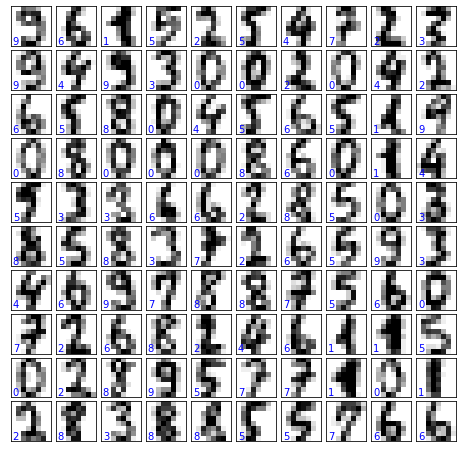

In [40]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate( axes.flat ):
    ax.imshow(X_test[i, :].reshape(8, 8), cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_test[i]),
            transform=ax.transAxes, color='blue')
    ax.set_xticks([])
    ax.set_yticks([])

第一张图片是数字 2，它是偶数 (标签 1 为 true)，小于等于 4 (标签 2 为 true)。

In [41]:
print(y_test[: 1])
print(ova_ml.predict(X_test[:1, :]))

[9]
[[0 1]]


### 4.3 Multioutput 估计器

`sklearn.multioutput`可以处理多输出(multi-output)的分类问题

多输出分类是多标签分类的泛化，在这里每一个标签可以是多类别 (大于两个类别) 的。一个例子就是预测图片每一个像素(标签) 的像素值是多少 (从 0 到 255 的 256 个类别)。

<img src='./pictures/Multioutput.jpg'>

Multioutput 估计器有两个：
- `MultiOutputRegressor` : 多输出回归
- `MultiOutputClassifier` : 多输出分类

本节只关注「多输出分类」

#### 4.3.1 MultiOutputClassifier

首先引入`MultiOutputClassifier`和`RandomForestClassifier`。

这两个都是元估计器，因此可以随意组合。

In [42]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

在手写数字的例子上，我们也为特意每个数字设计了多标签而且每个标签的类别都大于二。

- 标签1 - 小于等于4， 4 到 7 之间，大于等于7（三类）
- 标签2 - 数字本身（十类）

In [44]:
y_train_1st = y_train.copy()
y_train_1st[y_train <= 4] = 0  # 小于等于 4 
y_train_1st[np.logical_and(y_train > 4, y_train < 7)] = 1  # 4 到 7 之间
y_train_1st[y_train >= 7] = 2  # 大于等于 7

y_train_multioutput = np.c_[y_train_1st, y_train]
y_train_multioutput

array([[2, 8],
       [0, 1],
       [2, 8],
       ...,
       [0, 4],
       [0, 2],
       [1, 6]])

用含有 100 棵决策树的随机森林来解决这个多输入分类问题

In [46]:
MO = MultiOutputClassifier(RandomForestClassifier(n_estimators=100))
MO.fit(X_train, y_train_multioutput)

MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                       n_jobs=None,
                    

看看模型在测试集前的五张照片上的预测

In [47]:
MO.predict(X_test[:5, :])

array([[2, 9],
       [1, 6],
       [0, 1],
       [2, 9],
       [0, 2]])

这个 ndarray 第一列是标签 1 的类别，第二列是标签 2 的类别。预测结果是这五张照片分别显示数字 9, 6, 1, 9, 2（标签2）

再看看真实标签：

In [48]:
y_test_1st = y_test.copy()
y_test_1st[y_test < 4] = 0
y_test_1st[np.logical_and(y_test > 4, y_test < 7)] = 1
y_test_1st[y_test >= 7] = 2

y_test_multioutput = np.c_[y_test_1st, y_test]

In [49]:
y_test_multioutput[:5]

array([[2, 9],
       [1, 6],
       [0, 1],
       [1, 5],
       [0, 2]])

### 4.4 Model Selection 估计器

模型选择(Model Selection)在机器学习中非常重要，它主要用于评估模型表现，常见的 Model Selection 估计器有以下几个：
- `cross_validate` : 评估交叉验证的表现
- `learning_curve` : 建立学习曲线
- `GridSearchCV` : 用交叉验证从网格中一组超参数搜索出最佳超参数
- `RandomizedSearchCV` : 用交叉验证从一组随机超参数搜索出最佳超参数

本小节关注调节超参数的两个估计器，即上面列出的最后两个。它们都要用到交叉验证。

两个调参的估计器：`网格追踪`和`随机追踪`

<img src='./pictures/GridSearch.jpg'>

**网格追踪**：**参数1**在\[1, 10, 100, 1000\]中取值，**参数2**在\[0.01, 0.1, 1, 10\]中取值，注意并不是等间距取值。模型在所有 16 个组合跑，选取一对对应最小交叉验证误差的参数。

**随机追踪**： 根据指定分布随机搜索，可以选择独立于参数个数，比如 log(参数1)服从 0 到 3 的均匀分布，log(参数2)服从 -2 到 1 的均匀分布。此外，会设定一个预算参数。

In [56]:
from time import time
from scipy.stats import randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

X, y = digits.data, digits.target

RFC = RandomForestClassifier(n_estimators=20)

# Randomized Search 
param_dist = {"max_depth": [3, 5],
              "max_features": randint(1, 11),
              "min_samples_split": randint(2, 11),
              "criterion": ['gini', 'entropy']}

n_iter_search = 20
random_search = RandomizedSearchCV(RFC, param_distributions=param_dist, n_iter=n_iter_search, cv=5)

start = time()
random_search.fit(X, y)
print(f"RandomizedSearchCV took {time() - start:.2f} seconds for {n_iter_search} candidates parameter settings.")
print(random_search.best_params_)
print(random_search.best_score_)

# Grid Search
param_grid = {"max_depth": [3, 5],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "criterion": ['gini', 'entropy']}

grid_search = GridSearchCV(RF, param_grid=param_grid, cv=5)
start = time()
grid_search.fit(X, y)

print(f"\nGridSearchCV took {time() - start:.2f} secondes for {len(grid_search.cv_results_['params'])} candidate parameter settings.")
print(grid_search.best_params_)
print(grid_search.best_score_)

RandomizedSearchCV took 2.22 seconds for 20 candidates parameter settings.
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 10, 'min_samples_split': 8}
0.890929326655537

GridSearchCV took 1.04 secondes for 36 candidate parameter settings.
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 10, 'min_samples_split': 3}
0.8319421257651641


D:\Users\liu59\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


解释一下代码：

- 前 10 行就是引入各种包，并准备好 X 和 y，创建一个含 20 个决策树的随机森林模型，那么它有超参数最大树深、最多特征数、最小可分裂样本数、和分裂标准。

- 第 12-27 行是运行`随机追踪`，关键点是建立了一个参数分布 (`param_dist`)，而且还预先设定了个迭代组数 `n_iter_search=20`。

第 22-42 行是运行`网格追踪`，关键点是建立了一个参数网格 (`param_grid`)。

解释一下运行结果：

- 第一行输出每种追踪法运行的多少次和花的时间。
- 第二行输出最佳超参数的组合。
- 第三行输出最高得分。

由上面结果可知，`随机追踪`比`网格追踪`用更短时间内找到一组超参数，获得了更高的得分。???

### 4.5 Pipeline 估计器

Pipeline 估计器又叫流水线，把各种估计器以串联(Pipeline)或并联(FeatureUnion)的方式组成一条龙服务。

用好了它真的能大大提高效率。

#### 4.5.1 Pipeline

`Pipeline` 将若干个估计器按顺序连在一起，比如

    特征提取 -> 降维 -> 拟合 -> 预测

在整个 `Pipeline` 中，它的属性永远和最后一个估计器属性一样

- 如果最后一个估计器是预测器，那么 `Pipeline` 是预测器
- 如果最后一个估计器是转换器，那么 `Pipeline` 是转换器

下面用一个简单例子来说明如果用 `Pipeline` 来做「先填补缺失值-再标准化」这两步的。先生成含缺失值 NaN 的数据 X。


In [57]:
X = np.array([[50, 40, 30, 5, 7, 10, 9, np.NaN, 12],
              [1.68, 1.83, 1.77, np.NaN, 1.9, 1.65, 1.88, np.NaN, 1.75]])
X = np.transpose(X)
X

array([[50.  ,  1.68],
       [40.  ,  1.83],
       [30.  ,  1.77],
       [ 5.  ,   nan],
       [ 7.  ,  1.9 ],
       [10.  ,  1.65],
       [ 9.  ,  1.88],
       [  nan,   nan],
       [12.  ,  1.75]])

首先引入`Pipeline`，再引入
- 处理缺失值的转换器 `SimpleImputer`
- 做规划化的转换器 `MinMaxScaler`

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

In [60]:
pipe = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('normalize', MinMaxScaler())
])

第 1-4 行创建了流水线，范式非常简单，就在 Pipeline() 里一个输入「含名称的估计器的列表」。`SimpleImputer` 起名叫 `impute`，`MinMaxScaler` 起名叫 `normalize`。

由于最后一个估计器是转换器，因此 `pipe` 也是个转换器。写好了就可以那它来做「先填补缺失值-再标准化」的重复工作了。

看看运行结果，值都被填满了，而且两列也被标准化了。

In [61]:
X_proc = pipe.fit_transform( X )
X_proc

array([[1.        , 0.12      ],
       [0.77777778, 0.72      ],
       [0.55555556, 0.48      ],
       [0.        , 0.52      ],
       [0.04444444, 1.        ],
       [0.11111111, 0.        ],
       [0.08888889, 0.92      ],
       [0.34166667, 0.52      ],
       [0.15555556, 0.4       ]])

为验证上面流水线的参数，我们可以按顺序来运行这两个转换器，结果是一样的

In [62]:
X_impute = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform( X )
X_impute

array([[50.   ,  1.68 ],
       [40.   ,  1.83 ],
       [30.   ,  1.77 ],
       [ 5.   ,  1.78 ],
       [ 7.   ,  1.9  ],
       [10.   ,  1.65 ],
       [ 9.   ,  1.88 ],
       [20.375,  1.78 ],
       [12.   ,  1.75 ]])

In [63]:
X_normalize = MinMaxScaler().fit_transform( X_impute )
X_normalize

array([[1.        , 0.12      ],
       [0.77777778, 0.72      ],
       [0.55555556, 0.48      ],
       [0.        , 0.52      ],
       [0.04444444, 1.        ],
       [0.11111111, 0.        ],
       [0.08888889, 0.92      ],
       [0.34166667, 0.52      ],
       [0.15555556, 0.4       ]])

#### 4.5.2 FeatureUnion

如果想在一个节点同时运行几个估计器，可用`FeatureUnion`。

下例首先建立一个`DataFrame`

- 前两列智力 IQ 和脾气 temper 都是分类型变量
- 后两列收入 income 和身高 height 都是数值型变量
- 每列中都有缺失值

In [67]:
d = {"IQ": ['high', 'avg', 'avg', 'low', 'high', 'avg', 'high', 'high', None],
     'temper': ['good', None, 'good', 'bad', 'bad', 'bad', 'bad', None, 'bad'],
     'income': [50, 40, 30, 5, 7, 10, 9, np.NaN, 12],
     'height': [1.68, 1.83, 1.77, np.NaN, 1.9, 1.65, 1.88, np.NaN, 1.75]}
X = pd.DataFrame( d )
X

,IQ,temper,income,height
0,high,good,50.0,1.68
1,avg,None,40.0,1.83
2,avg,good,30.0,1.77
3,low,bad,5.0,NaN
4,high,bad,7.0,1.90
5,avg,bad,10.0,1.65
6,high,bad,9.0,1.88
7,high,None,NaN,NaN
8,None,bad,12.0,1.75


我们现在按下列步骤来清洗数据。

- 对**分类**型变量：获取 -> 中位数填充 -> 独热编码
- 对**数值**型变量：获取 -> 均值填充 -> 标准化

上面两步是平行进行的。

首先我们自己定义一个从 `DataFrame` 里面获取每列的类，起名叫 `DataFrameSelector`。

In [69]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

接下来建立一个流水线 `full_pipe`，它并联着两个流水线

- `categorical_pipe` 处理**分类**型变量
    + `DataFrameSelector` 用来获取
    + `SimpleImputer` 用出现最多的值来填充 None
    + `OneHotEncoder` 来编码返回非稀疏矩阵
- `numeric_pipe` 处理**数值**型变量
    + `DataFrameSelector` 用来获取
    + `SimpleImputer` 用均值来填充 NaN
    + `normalize` 用来规范化数值

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

categorical_features = ["IQ", "tempter"]
numeric_features = ['income', 'height']

categorical_pipe = Pipeline([
    ('select', DataFrameSelector(categorical_features)),
    ('impute', SimpleImputer(missing_values=None, strategy='most_frequent')),
    ('one_hot_encode', OneHotEncoder(sparse=False))
])

numeric_pipe = Pipeline([
    ('select', DataFrameSelector(categorical_features)),
    ('impute', SimpleImputer(missing_values=None, strategy='most_frequent')),
    ('normalize', MinMaxScaler())
])

full_pipe = FeatureUnion(transformer_list = [
    ('numeric_pipe', numeric_pipe),
    ('categorical_pipe', categorical_pipe)
])

In [74]:
X_proc = full_pipe.fit_transform( X )
X_proc

KeyError: "['tempter'] not in index"